In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
import csv
import random
import time
import pystan
import pandas as pd


In [5]:
def logit(z): return 1./(1.+np.exp(-z))

In [6]:
def convert_race(race):
    if race == 'Z':
        return 1
    elif race == 'P':
        return 2
    elif race == 'T':
        return 3
    else:
        return 4
    

def load_data_stan(file_name, pk=1, edge=3, nk=5):
    with open(file_name, encoding='utf-8') as f: lines = f.read().split('\n')
    p = 0; playerid = {};
    for i in range(len(lines)):
        csv = lines[i].split(',')
        if len(csv) != 10: continue   # parse error or blank line
        player0,player1 = csv[1],csv[4]
        if player0 not in playerid: playerid[player0]=p; p+=1
        if player1 not in playerid: playerid[player1]=p; p+=1

    nplayers = len(playerid)
    playername = ['']*nplayers
    for player in playerid:
        playername[ playerid[player] ]=player;  # id to name lookup


    pKeep = pk   # fraction of edges to consider (immed. throw out 1-p edges)
    nEdge = edge     # try to keep nEdge opponents per player (may be more; asymmetric)
    nKeep = nk     # keep at most nKeep games per opponent pairs (play each other multiple times)

    count = 0
    nplays, nwins = np.zeros( (nplayers,nplayers) ), np.zeros( (nplayers,nplayers) );
    player_A = []
    player_B = []
    wins = []
    RA = []
    RB = []
    for i in range(len(lines)):
        csv = lines[i].split(',')
        if len(csv) != 10: continue;   # parse error or blank line
        a,b = playerid[csv[1]],playerid[csv[4]];
        aw,bw = csv[2]=='[winner]',csv[5]=='[winner]';
        if (np.random.rand() < pKeep):
            if (nplays[a,b] < nKeep) and ( ((nplays[a,:]>0).sum() < nEdge) or ((nplays[:,b]>0).sum() < nEdge) ):
                count += 1
                nplays[a,b] += 1; nplays[b,a]+=1; nwins[a,b] += aw; nwins[b,a] += bw;
                player_A.append(a+1)
                player_B.append(b+1)
                wins.append(aw)
                RA.append(convert_race(csv[6]))
                RB.append(convert_race(csv[7]))

    win_re = []
    for i in wins:
        if i:
            win_re.append(1)
        else:
            win_re.append(0)
    print(RB)
    return player_A,player_B,win_re,RA,RB, playerid, playername

In [7]:

# skill_model = """
# data {
#   int<lower=1> N;             # Total number of players
#   int<lower=1> E;             # number of games
#   real<lower=0> scale;        # scale value for probability computation
#   int<lower=0,upper=1> win[E]; # PA wins vs PB
#   int PA[E];                  # player info between each game
#   int PB[E];                  # 
# }
# parameters {
#   vector [N] skill;           # skill values for each player
# }

# model{
#   for (i in 1:N){ skill[i]~normal(0,10); }
#   for (i in 1:E){
#     win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]]-skill[PB[i]]) );
#   }   # win probability is a logit function of skill difference
# }
# """

skill_model = """
data {
  int<lower=1> N;             # Total number of players
  int<lower=1> E;             # number of games
  real<lower=0> scale;        # scale value for probability computation
  int<lower=0,upper=1> win[E]; # PA wins vs PB
  int PA[E];                  # player info between each game
  int PB[E];                  # 
  int RA[E];
  int RB[E];
}
parameters {
  vector [N] skill;           # skill values for each player
  vector [N] R1;
  vector [N] R2;
  vector [N] R3;
}

model{
  for (i in 1:N){ skill[i]~normal(0,10);
                  R1[i] ~ normal(0,1.5);
                  R2[i] ~ normal(0,1.5);
                  R3[i] ~ normal(0,1.5);}
                  
  for (i in 1:E){
  if(RA[i] == 1 && RB[i] == 1)
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]] + R1[PA[i]] - skill[PB[i]] - R1[PB[i]]) );
  else if(RA[i] == 1 && RB[i] == 2)
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]] + R2[PA[i]] - skill[PB[i]] - R1[PB[i]]) );
  else if(RA[i] == 1 && RB[i] == 3)
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]] + R3[PA[i]] - skill[PB[i]] - R1[PB[i]]) );
  else if(RA[i] == 2 && RB[i] == 1)
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]] + R1[PA[i]] - skill[PB[i]] - R2[PB[i]]) );
  else if(RA[i] == 2 && RB[i] == 2)
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]] + R2[PA[i]] - skill[PB[i]] - R2[PB[i]]) );
  else if(RA[i] == 2 && RB[i] == 3)
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]] + R3[PA[i]] - skill[PB[i]] - R2[PB[i]]) );
  else if(RA[i] == 3 && RB[i] == 1)
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]] + R1[PA[i]] - skill[PB[i]] - R3[PB[i]]) );
  else if(RA[i] == 3 && RB[i] == 2)
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]] + R2[PA[i]] - skill[PB[i]] - R3[PB[i]]) );
  else if(RA[i] == 3 && RB[i] == 3)
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]] + R3[PA[i]] - skill[PB[i]] - R3[PB[i]]) );
  else
    win[i] ~ bernoulli_logit( (scale)*(skill[PA[i]]-skill[PB[i]]) );
    
  }   # win probability is a logit function of skill difference
}
"""

In [8]:
import pickle

try:     # load it if already compiled
    sm = pickle.load(open('skill_model3.pkl', 'rb'))
except:  # ow, compile and save compiled model
    sm = pystan.StanModel(model_code = skill_model)
    with open('skill_model3.pkl', 'wb') as f: pickle.dump(sm, f)



In [68]:

player_A,player_B,win_re,RA,RB,playerid, playername = load_data_stan("train.csv",1,64,20)
print(len(win_re))


[2, 1, 3, 1, 2, 3, 1, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 2, 3, 1, 2, 1, 1, 3, 2, 1, 1, 2, 1, 3, 1, 3, 1, 1, 2, 3, 2, 1, 2, 3, 1, 3, 1, 1, 3, 2, 3, 2, 1, 2, 2, 1, 3, 3, 2, 2, 1, 2, 2, 3, 2, 1, 2, 2, 1, 2, 2, 1, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 1, 3, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 3, 1, 3, 3, 3, 1, 2, 1, 1, 1, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 3, 1, 3, 1, 1, 1, 3, 2, 2, 2, 3, 1, 1, 2, 1, 3, 1, 3, 1, 1, 2, 3, 3, 2, 2, 2, 3, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 3, 2, 1, 2, 3, 2, 1, 1, 2, 2, 1, 3, 2, 3, 2, 3, 1, 3, 1, 1, 3, 1, 3, 2, 3, 1, 3, 1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 1, 3, 2, 3, 1, 2, 1, 3, 1, 2, 2, 3, 1, 3, 3, 3, 2, 1, 3, 2, 1, 2, 3, 3, 1, 1, 1, 2, 1, 2, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 3, 2, 1, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 3, 1, 3, 2, 3, 3, 1, 1, 2, 1, 3, 3, 3, 2, 3, 3, 3, 1, 3, 2, 3, 2, 1, 3, 2, 2, 1, 3, 1, 3, 2, 2, 1, 2, 1, 2, 1, 3, 1, 3, 1, 

In [69]:
# skill_data = {
#     'N': 999,
#     'E': 16788,
#     'scale': 0.5,
#     'win':win_re,
#     'PA': player_A,
#     'PB': player_B
# }

skill_data = {
    'N': 999,
    'E': 126129,
    'scale': 1,
    'win':win_re,
    'PA': player_A,
    'PB': player_B,
    'RA': RA,
    'RB': RB
}


In [70]:
fit = sm.sampling(data=skill_data, iter=200, chains=2)
samples = fit.extract()



To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
def load_data(file_name):
    data=pd.read_csv(file_name,index_col=False,
                     names=['date', 'p1', 'p1_outcome', 'score', 'p2', 'p2_outcome', 'p1_race', 'p2_race', 'addon', 'type'])
    #drop other columns for now
    data.drop(columns=['date','score','p2_outcome', 'addon', 'type'], inplace=True)
    data['p1_outcome'].replace({"[loser]":0,"[winner]":1},inplace=True)
    return data

valid_data = load_data('valid.csv')
print(valid_data)
valid_data['p1'].replace(playerid,inplace=True)
valid_data['p2'].replace(playerid,inplace=True)
valid_games=[tuple((r[0],r[2],r[1],r[3],r[4])) for r in valid_data.to_numpy()]
#valid_games


           p1  p1_outcome       p2 p1_race p2_race
0          MC           1  NaTuRal       P       T
1          MC           0     Cure       P       T
2          MC           1  Journey       P       T
3          MC           0    Trust       P       P
4          MC           0  Billowy       P       P
...       ...         ...      ...     ...     ...
94002  Keiras           0   Dragon       Z       T
94003  Keiras           0     nExt       Z       Z
94004  Keiras           0      EJK       Z       T
94005  Keiras           0    DeViL       Z       Z
94006  Keiras           0      HuK       Z       P

[94007 rows x 5 columns]


In [13]:

def logit(z): return 1./(1.+np.exp(-z))
def validate(fits, valid_games, n_games):
    accuracy = []
    for fit in fits:
        samples = fits[fit].extract()
        print(samples['R1'])
        print(samples['skill'])
        acc, acc_simulate = 0, 0
        n = n_games
        #for g in valid_games[:n_games]:
        for g in [valid_games[i] for i in np.random.choice(len(valid_games), n, replace = False)]:
            try:
                i,j,result,ra,rb=int(g[0]),int(g[1]),int(g[2]),convert_race(g[3]),convert_race(g[4])
            except:
                n-=1
                continue
            if(ra == 1 and rb == 1):
                prob = logit( skill_data['scale']*(samples['skill'][:,i] + samples['R1'][:,i] - samples['skill'][:,j] - samples['R1'][:,j] ) ).mean()
            elif(ra == 1 and rb == 2):
                prob = logit( skill_data['scale']*(samples['skill'][:,i] + samples['R2'][:,i] - samples['skill'][:,j] - samples['R1'][:,j] ) ).mean()
            elif(ra == 1 and rb == 3):
                prob = logit( skill_data['scale']*(samples['skill'][:,i] + samples['R3'][:,i] - samples['skill'][:,j] - samples['R1'][:,j] ) ).mean()
            elif(ra == 2 and rb == 1):
                prob = logit( skill_data['scale']*(samples['skill'][:,i] + samples['R1'][:,i] - samples['skill'][:,j] - samples['R2'][:,j] ) ).mean()
            elif(ra == 2 and rb == 2):
                prob = logit( skill_data['scale']*(samples['skill'][:,i] + samples['R2'][:,i] - samples['skill'][:,j] - samples['R2'][:,j] ) ).mean()
            elif(ra == 2 and rb == 3):
                prob = logit( skill_data['scale']*(samples['skill'][:,i] + samples['R3'][:,i] - samples['skill'][:,j] - samples['R2'][:,j] ) ).mean()
            elif(ra == 3 and rb == 1):
                prob = logit( skill_data['scale']*(samples['skill'][:,i] + samples['R1'][:,i] - samples['skill'][:,j] - samples['R3'][:,j] ) ).mean()
            elif(ra == 3 and rb == 2):
                prob = logit( skill_data['scale']*(samples['skill'][:,i] + samples['R2'][:,i] - samples['skill'][:,j] - samples['R3'][:,j] ) ).mean()
            elif(ra == 3 and rb == 3):
                prob = logit( skill_data['scale']*(samples['skill'][:,i] + samples['R3'][:,i] - samples['skill'][:,j] - samples['R3'][:,j] ) ).mean()
            else:
                prob = logit( skill_data['scale']*(samples['skill'][:,i] - samples['skill'][:,j]) ).mean()
            pred = 1 if prob > 0.5 else 0 #
            pred_simulate = np.random.choice([1,0], p=[prob, 1-prob])
            acc += (pred==result)
            acc_simulate += (pred_simulate==result)
        accuracy.append((acc/n, acc_simulate/n))
    return accuracy


In [79]:
accuracy = validate({1:fit}, valid_games, len(valid_games))


[[-0.80891501  1.08927862 -1.57593505 ... -1.2460478  -1.58151883
   1.86928079]
 [ 0.32087438  0.14870887  0.72461236 ... -1.62343758 -0.93216819
   3.59337218]
 [-1.43117475 -1.85440287  0.03956314 ... -0.13786727 -1.41984316
   3.1291689 ]
 ...
 [ 0.6471956  -0.71842591 -0.24514037 ... -2.27895533 -0.63955682
   1.11267468]
 [-0.23374131  0.02575755 -1.32891603 ...  0.28252501 -1.30574757
   0.29458064]
 [ 0.41991666  0.1842768  -1.46237344 ... -2.47755735 -1.54149131
   2.83045309]]
[[ 2.44118479  1.46522202  4.12564504 ... -1.59685495  0.14401781
  -2.87411927]
 [ 1.61020551  2.38899467  2.09878768 ... -1.61587828 -1.15977051
  -3.13374002]
 [ 3.91092928  4.97241421  3.52150078 ... -1.78395508  0.53470303
  -3.74255903]
 ...
 [ 1.45028258  3.33073193  2.80184132 ...  0.24110612 -1.19586516
  -2.82231282]
 [ 2.66090636  2.93029324  4.20742937 ... -3.02357473 -0.93801471
  -1.63137091]
 [ 1.69081311  2.80779226  4.10086525 ... -0.06014668 -0.69781538
  -2.71563232]]


In [75]:
data_num = [2808,6608,14370,29739,60596,102716,127579]


In [80]:
race_model = [ 0.5549801716893423, 0.5729998829874371, 0.5857223398257576,0.5969823583350176,0.6088358249917559,0.609944163732488, 0.608912176752795,0.607844163732488]

In [87]:
model_result = [0.5607,0.5772,0.5961,0.6049,0.6091,0.6043,0.6077] 

In [90]:
model_counter = [0.5635963279330263,
 0.5811801248843171,
 0.59439190698565,
 0.6047955365026009,
 0.6075294499345794,
 0.6049443126575681,
 0.6030827491569777]

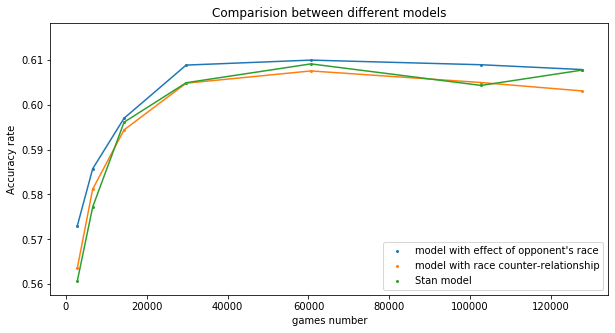

In [92]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
    
       
    
plt.scatter(data_num, race_model[1:], marker='.' ,label = "model with effect of opponent's race",linewidths=0.01)
plt.errorbar(data_num, race_model[1:], capsize = 5)
plt.scatter(data_num,model_counter, marker='.' ,label = "model with race counter-relationship",linewidths=0.01)
plt.errorbar(data_num, model_counter, capsize = 5)
plt.scatter(data_num, model_result, marker='.' ,label = 'Stan model',linewidths=0.01)
plt.errorbar(data_num,  model_result, capsize = 5)
plt.title("Comparision between different models")
plt.xlabel("games number")
plt.ylabel("Accuracy rate")
plt.legend()
plt.show()